In [55]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.metrics import pairwise_distances
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler

def get_consistency_rarity_per_user(df_user):
    
    name = df_user['name'].values[0]
    user = df_user['user'].values[0]
    y = df_user['y'].values
    if len(y)==np.sum(y) or len(y)<300:
        return pd.DataFrame([],columns=['name','user','consistency','rarity'])
    X = np.array([np.array(a) for a in df_user['distance'].values])
    distance_matrix = pairwise_distances(X)
    
    # for k in range(distance_matrix.shape[0]):
    #     distance_matrix[k,:] = distance_matrix[:,k]/np.max(distance_matrix[:,k])    
    n = len(y)
    # distance_matrix = winsorize(distance_matrix.reshape(-1),limits=[0,.1]).reshape(n,n)    
    # distance_matrix = distance_matrix/np.max(distance_matrix.reshape(-1))
    positive_to_all_distance = distance_matrix[y==1,:]
    positive_to_positive_distance = positive_to_all_distance[:,y==1]
    average_positive_to_positive_distance = positive_to_positive_distance.mean(axis=1)
    distance_80 = np.percentile(average_positive_to_positive_distance,80)
    negative_to_all_distance = distance_matrix[y==0,:]
    negative_to_positive_distance = negative_to_all_distance[:,y==1]
    average_negative_to_positive_distance = negative_to_positive_distance.mean(axis=1)
    n_negative = len(y[y==0])
    rare_positive = len(average_negative_to_positive_distance[average_negative_to_positive_distance<=distance_80])
    rare_positive_ratio = rare_positive/n_negative
    try:
        alpha = np.float(name[-3:])
    except:
        alpha = .1
    # print(alpha)
    return pd.DataFrame([[name,user,distance_80,rare_positive_ratio,np.square(rare_positive_ratio-alpha),alpha]],columns=['name','user','consistency','rarity','rarity-alpha','alpha'])



softmax_weight = 10
n_lag= 15
obs = 30
n_cluster = 4
revised_loss_weights = [50]
ratio_of_pos_to_negs = [.1,.2,.25,.3001,.35,.4,.45]

all_data = []
for weight in revised_loss_weights:
    for ratio in ratio_of_pos_to_negs:
        filename = './data/output_final_all/distance_lag_{}_obs_{}_triplet_loss_cluster_{}_revised_loss_alpha_{}_softmax_{}_loss_{}_rare_{}_positive_{}_percentile_{}.p'.format(n_lag,obs,n_cluster,ratio,softmax_weight,weight,1,.2,80)
        if not os.path.isfile(filename):
            continue
        if weight==0 or ratio==.1:
            filename = './data/output_final_all/distance_lag_15_obs_30_triplet_loss_cluster_4_triplet_loss_alpha_0.2_softmax_1_loss_1_rare_1_positive_0.2_percentile_80.p'
            name = 'Triplet\nLoss'
        else:
            name = 'RP Loss\n'+r'$\alpha$'+'={:.2f}'.format(ratio)
        print(name)
        final_y_time,final_probs,final_y,final_groups,bias_dict,val_results,final_dist = pickle.load(open(filename,'rb'))
        print(name,final_dist.shape)
        if final_dist.shape[1]>10:
            if name=='Triplet\nLoss':
                # print(final)
                distance = np.mean(final_dist[:,:,:],axis=1)
            else:
                distance = np.mean(final_dist[:,:10,:],axis=1)
        else:
            distance = final_dist.mean(axis=1)
        y = final_y
        df = pd.DataFrame({'y':np.int64(y),'distance':list(distance),'user':final_groups,'name':[name]*len(y)})
        results = df.groupby(['name','user'],as_index=False).apply(get_consistency_rarity_per_user)
        all_data.append(results)
df_final = pd.concat(all_data)

RP Loss
$\alpha$=0.20
RP Loss
$\alpha$=0.20 (27959, 50, 10)
RP Loss
$\alpha$=0.25
RP Loss
$\alpha$=0.25 (27959, 50, 10)
RP Loss
$\alpha$=0.30
RP Loss
$\alpha$=0.30 (27959, 50, 10)
RP Loss
$\alpha$=0.35
RP Loss
$\alpha$=0.35 (27959, 50, 10)
RP Loss
$\alpha$=0.40
RP Loss
$\alpha$=0.40 (27959, 50, 10)


In [36]:
# df_triplet = df_final[df_final.name.isin(['Triplet Loss'])]
# df_final = df_final[~df_final.name.isin(['Triplet Loss'])]
df_final.groupby('name').mean()
# color_list


,consistency,rarity,rarity-alpha,alpha
name,,,,
RP Loss\n$\alpha$=0.20,0.048099,0.279100,0.098064,0.20
RP Loss\n$\alpha$=0.25,0.047746,0.267774,0.092430,0.25
RP Loss\n$\alpha$=0.30,0.046229,0.224580,0.079772,0.30
RP Loss\n$\alpha$=0.35,0.049909,0.260786,0.093243,0.35
RP Loss\n$\alpha$=0.40,0.048284,0.228116,0.110621,0.40


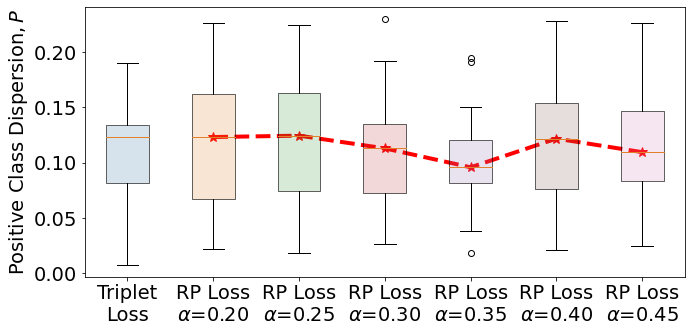

In [31]:
# fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
# ax2 = sns.swarmplot(x='name',y='consistency',data=df_final,ax=ax)
# for patch in ax1.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .2))
# sns.lineplot(x='name',y='consistency',data=df_final,ax=ax,ci=95,linewidth=10,estimator=np.median,linestyle='--',markers='*')
color_list = [[0.19460784313725488, 0.45343137254901944, 0.632843137254902],
 [0.8818627450980391, 0.5053921568627451, 0.17303921568627467],
 [0.22941176470588232, 0.5705882352941177, 0.22941176470588232],
 [0.7534313725490196, 0.23872549019607847, 0.24166666666666664],
 [0.5784313725490194, 0.446078431372549, 0.6990196078431372],
 [0.5171568627450981, 0.3583333333333334, 0.3259803921568628],
 [0.8372549019607844, 0.5196078431372548, 0.7401960784313724]]
sns.set_palette(sns.color_palette(color_list))
medianprops = dict(linestyle='-.', linewidth=.6)
plt.rcParams.update({'font.size':19.5})
plt.figure(figsize=(10,5))
rp_loss_data = [df_final[df_final.alpha==np.round(a*100)/100]['consistency'].values for a in ratio_of_pos_to_negs[1:]]
bplot = plt.boxplot([df_final[df_final.alpha==.1]['consistency'].values]+rp_loss_data,patch_artist=True,boxprops=medianprops)
for patch, color in zip(bplot['boxes'], color_list):
    patch.set_facecolor(color+[.2])
# ax1 = sns.boxplot(x='name',y='consistency',data=df_final[df_final.alpha!=.1],ax=ax)
# for patch in ax1.artist
    # r, g, b, a = patch.get_facecolor()
    # patch.set_facecolor((r, g, b, .2))
plt.ylabel('Positive Class Dispersion'+r'$, P$')
plt.xticks(np.arange(1,8),['Triplet\nLoss']+['RP Loss\n'+r'$\alpha$'+'={:.2f}'.format(ratio) for ratio in ratio_of_pos_to_negs[1:]])
plt.plot(np.arange(2,8),[np.median(a) for a in rp_loss_data],'--r*',linewidth=4,markersize=10)
# ax.set_xlabel('')
# # ax[0].set_xlabel('')
# # ax[1].set_xlabel('')
plt.tight_layout()
plt.savefig('./data/images/consistency.png')
plt.show()

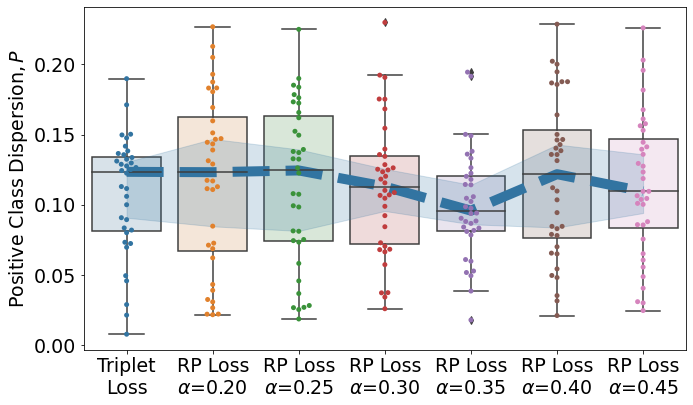

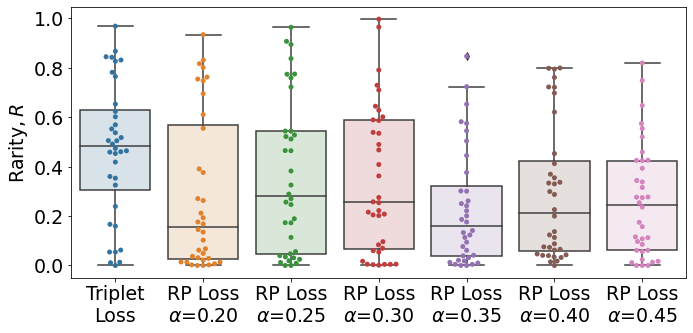

In [32]:
# %matplotlib inline
plt.rcParams.update({'font.size':19})
# # ,gridspec_kw={'width_ratios': [4, 1]}
fig,ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
ax1 = sns.boxplot(x='name',y='consistency',data=df_final,ax=ax)
ax2 = sns.swarmplot(x='name',y='consistency',data=df_final,ax=ax)
# color_list = []
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    # color_list.append([r,g,b])
    patch.set_facecolor((r, g, b, .2))

sns.lineplot(x='name',y='consistency',data=df_final,ax=ax,ci=95,linewidth=10,estimator=np.median,linestyle='--',markers='*')
ax.set_ylabel('Positive Class Dispersion'+r'$, P$')
ax.set_xlabel('')
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
plt.tight_layout()
# plt.savefig('./data/images/consistency.png')
plt.show()



plt.figure(figsize=(10,5))
# ax  =sns.barplot(x='name',y='rarity',data=df_final,alpha=.2,ci='sd')
ax  =sns.boxplot(x='name',y='rarity',data=df_final)
# ax = sns.boxplot(x='species', y='sepal_length', data=df)
# adding transparency to colors
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .2))
sns.swarmplot(x='name',y='rarity',data=df_final)
# sns.barplot(x='name',y='rarity',data=df_final,ci='sd',estimator=np.mean)
plt.ylabel('Rarity'+r'$, R$')
plt.xlabel('')
# plt.ylim([0,.3])
plt.tight_layout()
plt.savefig('./data/images/rarity.png')
plt.show()

# plt.figure(figsize=(12,8))
# sns.displot(x='rarity',hue='name',data=df_final,kind='hist')
# plt.ylabel('Rarity'+r'$, R$')
# plt.xlabel('')
# plt.show()


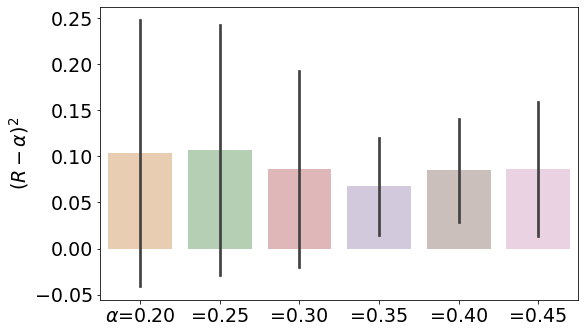

In [33]:
sns.set_palette(sns.color_palette(color_list[1:]))
plt.figure(figsize=(8.5,5))
ax = sns.barplot(x='name',y='rarity-alpha',data=df_final[df_final.alpha!=.1],ci='sd',alpha=.4)
plt.xticks(np.arange(6),[r'$\alpha$'+'={:.2f}'.format(.2)]+['={:.2f}'.format(ratio) for ratio in ratio_of_pos_to_negs[2:]])
plt.ylabel(r'$(R - \alpha)^2$')
plt.xlabel('')
plt.tight_layout()
plt.savefig('./data/images/rarity_alpha.png')
plt.show()

<AxesSubplot:xlabel='name', ylabel='consistency'>

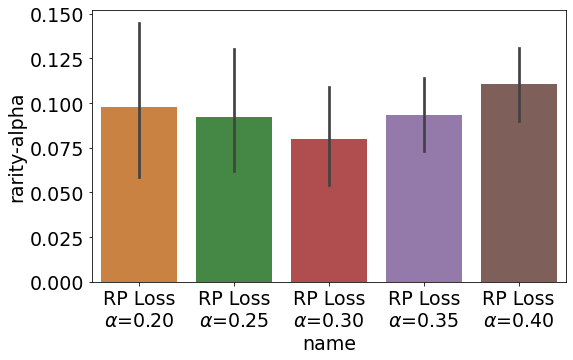

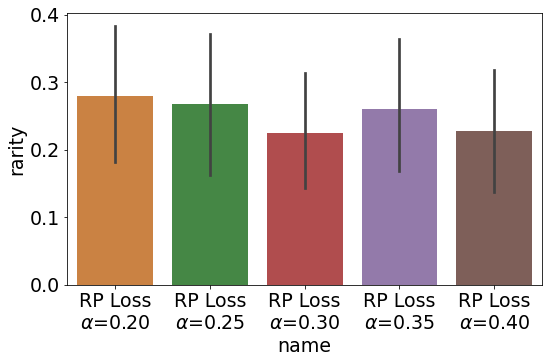

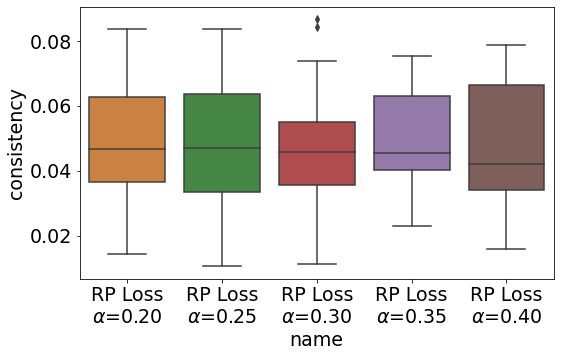

In [56]:
plt.figure(figsize=(8.5,5))
sns.barplot(x='name',y='rarity-alpha',data=df_final[df_final.alpha!=.1])
plt.figure(figsize=(8.5,5))
sns.barplot(x='name',y='rarity',data=df_final[df_final.alpha!=.1])
plt.figure(figsize=(8.5,5))
sns.boxplot(x='name',y='consistency',data=df_final[df_final.alpha!=.1])